In [1]:
import findspark
findspark.init("C:\\Users\\Owner\\scoop\\apps\\spark\\current",)

## RDDs

In [2]:
from pyspark import SparkContext, SparkConf
conf = SparkConf()# .setAppName("app-name-of-your-choice").setMaster("local[*]")
sc = SparkContext(conf=conf)
numbers = sc.parallelize(range(32))

In [3]:
numbers.sum()

496

In [4]:
numbers.count()

32

In [5]:
print(numbers.take(2))

[0, 1]


In [6]:
print(numbers.collect())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [8]:
numbers.filter(lambda x: x % 2 == 0)

PythonRDD[6] at RDD at PythonRDD.scala:52

In [7]:
numbers.filter(lambda x: x % 2 == 0).count()

16

In [9]:
(
    numbers
    .map(lambda x: x + 1)
    .filter(lambda x: x % 2 == 0)
    .map(lambda x: str(x) + " is even.")
    .collect()
)

['2 is even.',
 '4 is even.',
 '6 is even.',
 '8 is even.',
 '10 is even.',
 '12 is even.',
 '14 is even.',
 '16 is even.',
 '18 is even.',
 '20 is even.',
 '22 is even.',
 '24 is even.',
 '26 is even.',
 '28 is even.',
 '30 is even.',
 '32 is even.']

## Spark Configuration

In [10]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [11]:
import os
os.getpid()

4024

In [12]:
numbers.map(lambda x: os.getpid()).distinct().collect()

[12040, 11720, 3544, 2588, 6668, 12972, 2676, 10476]

## Example

C:\Users\Owner\scoop\apps\anaconda3\5.3.1\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


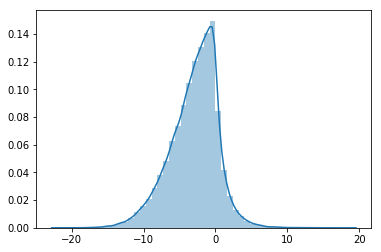

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(42)

simulated_data = np.random.randn(
    100000)**2 - 5 * np.abs(np.random.randn(100000))
sns.distplot(simulated_data)

In [14]:
def resample(data, seed):
    import numpy as np
    np.random.seed(seed)
    return data[np.random.randint(0, len(data), len(data))]


def boot_strap_mean(data, seed):
    return resample(data, seed).mean()

In [15]:
boot_strap_mean(simulated_data, 43)

-2.9750892668808113

In [16]:
seeds = np.arange(10000) + 42
samples = (
    sc.parallelize(seeds)
    .map(lambda seed: boot_strap_mean(simulated_data, seed))
)

In [17]:
samples.count()

10000

In [18]:
samples.mean()

-2.9832881825775894

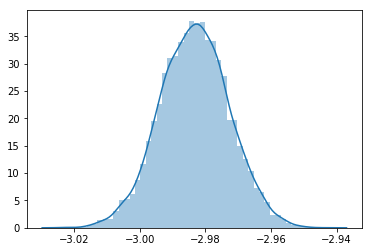

In [19]:
sns.distplot(samples.collect())

## Caching

In [20]:
%%timeit

samples.mean()

9.24 s ± 753 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
samples.persist()

PythonRDD[16] at collect at <ipython-input-19-271f851ee8a8>:1

In [22]:
samples.mean()

-2.9832881825775894

In [23]:
%%timeit 
samples.mean()

3.49 s ± 67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Local Execution

In [24]:
%%timeit 
samples_local = np.array([
    boot_strap_mean(simulated_data, seed)
for seed in seeds])

12.7 s ± 257 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Texting Parsing

In [25]:
raw_lines = sc.textFile("accor_data.txt")

In [26]:
import json

In [27]:
records = raw_lines.filter(lambda x: x != '').map(lambda x: json.loads(x))

In [28]:
records.take(3)

[{'created_at': 'Sat Dec 08 03:46:45 +0000 2018',
  'id': 1071249696654450688,
  'id_str': '1071249696654450688',
  'text': 'BOYS: FAIRMONT SENIOR POLAR BEARS 77, WYOMING EAST WARRIORS 58 (FAIRMONT SENIOR TOURNAMENT). More final scores: https://t.co/h8yMyFuPjr',
  'source': '<a href="http://www.basketballnight.com" rel="nofollow">Basketball Night</a>',
  'truncated': False,
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'in_reply_to_screen_name': None,
  'user': {'id': 865717002,
   'id_str': '865717002',
   'name': 'Basketball Night',
   'screen_name': 'Hoops_Roundup',
   'location': 'West Virginia',
   'url': 'https://basketballnight.com',
   'description': '3 hour live radio show recapping WV high school basketball every Friday night 9pm-midnight across West Virginia. WATCH OR LISTEN: https://t.co/7q0ilTGv7s',
   'translator_type': 'none',
   'protected': False,
   'verified': False,
   'follo

In [29]:
records.filter(lambda x: x['lang'] == 'en').count()

714

In [30]:
sc.range(1,5).collect()

[1, 2, 3, 4]

In [31]:
sc.range(1,5).map(lambda x: [i for i in range(x) ]).collect()

[[0], [0, 1], [0, 1, 2], [0, 1, 2, 3]]

In [32]:
sc.range(1,5).flatMap(lambda x: [i for i in range(x) ]).collect()

[0, 0, 1, 0, 1, 2, 0, 1, 2, 3]

In [33]:
word_counts = (
    records
        .map(lambda x: x['text'])     # extract the text
        .flatMap(lambda x: x.split()) # split on whitespace and
                                      # convert each word into a separate record.
        .filter(lambda x: len(x) > 2) # keep words that have 3 or more letters
        .map(lambda x: (x, 1))           # Count each word 
        .reduceByKey(lambda a, b: a + b) # Sum the counts
)

In [34]:
word_counts.map(lambda x: (x[1], x[0])).top(10)

[(2124, 'MERCI'),
 (538, 'est'),
 (534, 'Bercy'),
 (531, 'replay.'),
 (531, '4ème'),
 (530, 'https://t.co/bQN3hcWNGJ'),
 (530, '@Orel_san:'),
 (310, 'the'),
 (248, 'for'),
 (241, 'Fairmont')]

# Spark DataFrames

In [35]:
type(records)

pyspark.rdd.PipelinedRDD

In [36]:
from pyspark.sql import SparkSession
spark = SparkSession(sc)

In [37]:
spark

In [38]:
df = records.map(lambda x: [x['text']]).toDF()

In [39]:
df.show()

+--------------------+
|                  _1|
+--------------------+
|BOYS: FAIRMONT SE...|
|3月〜！！

受験受かってはぴはぴ...|
|RT @SunDevilWBB: ...|
|RT @DPrez304: Div...|
|愛媛のIBISっていう上級大尉にレ...|
|Karthik kickstart...|
|I just entered th...|
|Roadblock at the ...|
|RT @NRsports_NC: ...|
|I just entered th...|
|First drawing on ...|
|Mala idea venir a...|
|@ibisiro Ibis noO...|
|Fairmont Jakarta:...|
|RT @SunDevilWBB: ...|
|Le Club AccorHote...|
|RT @JoshMLowe: 17...|
|#NoTePases Te qui...|
|同じibisで塗ったっていうのが信...|
|@beltrandelrio @F...|
+--------------------+
only showing top 20 rows



In [40]:
pandas_df = df.toPandas()
pandas_df.head()

,_1
0,"BOYS: FAIRMONT SENIOR POLAR BEARS 77, WYOMING ..."
1,3月〜！！\n\n受験受かってはぴはぴになりながら従姉妹の家で遊んだのが1番楽しかった…\n...
2,"RT @SunDevilWBB: Hey @NkealHarry15,\n\nWe’re b..."
3,RT @DPrez304: Division 1 schools are sleeping ...
4,愛媛のIBISっていう上級大尉にレクスで覚醒使わず2落ちという捨てゲーされた😭
